In [1]:
import pandas as pd
import numpy as np

from src.models import CapitalManager, DaoParams
from src.simulation import AllocationSimulator

In [2]:
dao_params = DaoParams(
    alpha=0.6,
    beta=0,
    premium=0.02,
    min_bond=50000,
    penalty=0.01,
    epoch_length_hours=24*28,
    auction_length=-1,
    ema_window_risk_free=24*7,
    ema_window_reputation=30*24,
    slash_percent=0.01
)

In [3]:
data = pd.read_csv(
    'data/into_the_block_data_2024.csv',
    parse_dates=['DateTime'],
    index_col='DateTime'
).drop(columns=["Borrow APY", "Supply APY"]).rename(
    columns={
        'Net APY': 'net_apy',
        'Staking APY': 'staking_apy'
    }
)

# assuming a 10x leverage on the data, we simply take 
# the risk free rate (stETH base rate) as:
data['staking_apy'] = data['staking_apy'] / 10
data.rename(columns={'staking_apy': 'risk_free_rate'}, inplace=True)

# the risk free rate goes through an exponential moving average (7-D)
data["ema_riskfree"] = data["risk_free_rate"].ewm(
    span=7*24,  # 7 days * 24 hours
    adjust=False  # Use traditional EMA calculation
).mean()

data.drop(columns=['risk_free_rate'], inplace=True)
data

,net_apy,ema_riskfree
DateTime,,
2024-01-25 17:00:00,0.095773,0.025986
2024-01-25 18:00:00,0.094889,0.025986
2024-01-25 19:00:00,0.094905,0.025987
2024-01-25 20:00:00,0.094896,0.025987
2024-01-25 21:00:00,0.095693,0.025987
...,...,...
2025-01-22 11:00:00,0.105806,0.024897
2025-01-22 12:00:00,0.085278,0.024896
2025-01-22 13:00:00,0.066021,0.024871


In [4]:
managers = [
    CapitalManager(
        manager_id=f"CM_{i+1}",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=np.random.uniform(0.3, 0.6),
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    ) for i in range(3)
]

We add one irrational manager

In [5]:
managers.append(
    CapitalManager(
        manager_id=f"CM_Risk",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=0.9,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    )
)

We add one very conservative manager

In [6]:
managers.append(
    CapitalManager(
        manager_id=f"CM_Conservative",
        promised_yield=0,  # initialise it as zero and promise later after revealing bid floor
        strategy_risk=0.001,
        bond_amount=100000,
        realized_yield=0,
        allocated_capital=0,
        absolute_returns=0,
        score=0,
        reputation=1,
        score_history=None,  # Will be initialized to empty ScoreHistory
        to_penalise=False,
    )
)

In [7]:
simulator = AllocationSimulator(
    data=data,
    initial_managers=managers,
    dao_params=dao_params,
    initial_capital=10_000_000,
    strategy_liq_buffer=0.06,
)

In [8]:
print("Starting simulation...")
results = simulator.run_simulation()

# Analyze and display results
print("Simulation complete. Results summary:")
print(f"Total epochs simulated: {len(results)}")
print(f"Final total capital: {results.iloc[-1]['total_capital']:,.2f}")

Starting simulation...
$$$$$$$$$$$
epoch ID: 0
----
manager CM_1 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.09073046524783596 and realised 0.09174536517686317
manager's absolute profits in epoch: 14076.001232614624
manager scored 0.005504721910611795 and was allocated 2035733.7317494156
reputation score: 0.3965807619668999
----
manager CM_2 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.09208030214914636 and realised 0.09112263250480586
manager's absolute profits in epoch: 13980.458685668846
manager scored 0.005467357950288356 and was allocated 2021915.9448353227
reputation score: 0.3965580910372685
----
manager CM_3 stats for epoch
manager was allocated 2000000.0 at the start
manager promised 0.0960144194510932 and realised 0.08861273582862644
manager's absolute profits in epoch: 13595.378647679676
manager scored 0.0053167641497175915 and was allocated 1966223.961735639
reputation score: 0.39646671685139256
----
man

In [9]:
plot_df = results.copy()

columns = ['allocations', 'scores', 'realized_yields', 'reputation', 'absolute_returns', 'bond_amount']
        
# Unpack dictionary columns
for col in columns:
    expanded = plot_df[col].apply(pd.Series)
    expanded.columns = [f'{col}_{cid}' for cid in expanded.columns]
    plot_df = pd.concat([plot_df, expanded], axis=1)
    
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,allocations,scores,realized_yields,bond_amount,absolute_returns,reputation,...,absolute_returns_CM_1,absolute_returns_CM_2,absolute_returns_CM_3,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,bond_amount_CM_1,bond_amount_CM_2,bond_amount_CM_3,bond_amount_CM_Risk,bond_amount_CM_Conservative
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.006963e+07,0.025836,0.045836,"{'CM_1': 2035733.7317494156, 'CM_2': 2021915.9...","{'CM_1': 0.005504721910611795, 'CM_2': 0.00546...","{'CM_1': 0.09174536517686317, 'CM_2': 0.091122...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 14076.001232614624, 'CM_2': 13980.458...","{'CM_1': 0.3965807619668999, 'CM_2': 0.3965580...",...,14076.001233,13980.458686,13595.378648,16552.779079,11421.417564,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-02-22 00:00:00,1,1.014480e+07,0.026683,0.046683,"{'CM_1': 2050881.4906963657, 'CM_2': 2036844.4...","{'CM_1': 0.0023089747827765334, 'CM_2': 0.0022...","{'CM_1': 0.09703676208450943, 'CM_2': 0.096378...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 15153.83088839726, 'CM_2': 14948.8121...","{'CM_1': 0.15735269659321177, 'CM_2': 0.157334...",...,15153.830888,14948.812162,14136.648492,20955.869321,9977.089384,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-03-21 00:00:00,2,1.021701e+07,0.026750,0.046750,"{'CM_1': 2065425.7510538606, 'CM_2': 2051165.1...","{'CM_1': 0.0008734784870612286, 'CM_2': 0.0008...","{'CM_1': 0.09251811439869427, 'CM_2': 0.091890...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 14555.680204064405, 'CM_2': 14357.933...","{'CM_1': 0.062407479016078474, 'CM_2': 0.06239...",...,14555.680204,14357.933127,13574.743117,20158.530427,9568.053305,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-04-18 00:00:00,3,1.027820e+07,0.022280,0.042280,"{'CM_1': 2077741.2233820024, 'CM_2': 2063276.6...","{'CM_1': 0.00029143674560677495, 'CM_2': 0.000...","{'CM_1': 0.07783168251668732, 'CM_2': 0.077303...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 12331.933470955637, 'CM_2': 12163.662...","{'CM_1': 0.024717993985551388, 'CM_2': 0.02471...",...,12331.933471,12163.662101,11497.362865,17105.563556,8092.680855,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-05-16 00:00:00,4,1.034514e+07,0.024939,0.044939,"{'CM_1': 2091223.858728813, 'CM_2': 2076564.62...","{'CM_1': 0.0001254974907114693, 'CM_2': 0.0001...","{'CM_1': 0.08461952237765685, 'CM_2': 0.084045...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 13487.367557574513, 'CM_2': 13302.563...","{'CM_1': 0.009796268540300794, 'CM_2': 0.00979...",...,13487.367558,13302.563240,12570.956004,18736.216309,8836.744902,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-06-13 00:00:00,5,1.038660e+07,0.023164,0.043164,"{'CM_1': 122684.06889845757, 'CM_2': 121817.64...","{'CM_1': 3.0605955300376e-05, 'CM_2': 3.038980...","{'CM_1': 0.052070770917290884, 'CM_2': 0.05171...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 8353.331171424523, 'CM_2': 8238.47350...","{'CM_1': 0.003870862149985439, 'CM_2': 0.00386...",...,8353.331171,8238.473508,7783.854590,11618.785723,5465.608179,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-07-11 00:00:00,6,1.042353e+07,0.028176,0.048176,"{'CM_1': 90153.35617760367, 'CM_2': 89513.7534...","{'CM_1': 1.3086685893321682e-05, 'CM_2': 1.299...","{'CM_1': 0.05634699018051615, 'CM_2': 0.055964...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 530.3029718212613, 'CM_2': 522.983752...","{'CM_1': 0.001530121090342097, 'CM_2': 0.00152...",...,530.302972,522.983752,494.019162,738.615969,34647.009197,100000.0,100000.0,100000.0,100000.0,99000.00000
2024-08-08 00:00:00,7,1.045608e+07,0.022320,0.042320,"{'CM_1': 64550.562464930525, 'CM_2': 64090.343...","{'CM_1': 4.560126441322295e-06, 'CM_2': 4.5276...","{'CM_1': 0.04967064883628219, 'CM_2': 0.049333...","{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 1000

In [10]:
plot_df.dropna(inplace=True)
plot_df.drop(columns=["allocations", "scores", "realized_yields"], inplace=True)
plot_df

,epoch_id,total_capital,ema_risk_free,bid_floor,bond_amount,absolute_returns,reputation,allocations_CM_1,allocations_CM_2,allocations_CM_3,...,absolute_returns_CM_1,absolute_returns_CM_2,absolute_returns_CM_3,absolute_returns_CM_Risk,absolute_returns_CM_Conservative,bond_amount_CM_1,bond_amount_CM_2,bond_amount_CM_3,bond_amount_CM_Risk,bond_amount_CM_Conservative
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-25 17:00:00,0,1.006963e+07,0.025836,0.045836,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 14076.001232614624, 'CM_2': 13980.458...","{'CM_1': 0.3965807619668999, 'CM_2': 0.3965580...",2.035734e+06,2.021916e+06,1.966224e+06,...,14076.001233,13980.458686,13595.378648,16552.779079,11421.417564,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-02-22 00:00:00,1,1.014480e+07,0.026683,0.046683,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 15153.83088839726, 'CM_2': 14948.8121...","{'CM_1': 0.15735269659321177, 'CM_2': 0.157334...",2.050881e+06,2.036844e+06,1.980285e+06,...,15153.830888,14948.812162,14136.648492,20955.869321,9977.089384,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-03-21 00:00:00,2,1.021701e+07,0.026750,0.046750,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 14555.680204064405, 'CM_2': 14357.933...","{'CM_1': 0.062407479016078474, 'CM_2': 0.06239...",2.065426e+06,2.051165e+06,1.993722e+06,...,14555.680204,14357.933127,13574.743117,20158.530427,9568.053305,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-04-18 00:00:00,3,1.027820e+07,0.022280,0.042280,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 12331.933470955637, 'CM_2': 12163.662...","{'CM_1': 0.024717993985551388, 'CM_2': 0.02471...",2.077741e+06,2.063277e+06,2.005029e+06,...,12331.933471,12163.662101,11497.362865,17105.563556,8092.680855,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-05-16 00:00:00,4,1.034514e+07,0.024939,0.044939,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 13487.367557574513, 'CM_2': 13302.563...","{'CM_1': 0.009796268540300794, 'CM_2': 0.00979...",2.091224e+06,2.076565e+06,2.017546e+06,...,13487.367558,13302.563240,12570.956004,18736.216309,8836.744902,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-06-13 00:00:00,5,1.038660e+07,0.023164,0.043164,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 8353.331171424523, 'CM_2': 8238.47350...","{'CM_1': 0.003870862149985439, 'CM_2': 0.00386...",1.226841e+05,1.218176e+05,1.183303e+05,...,8353.331171,8238.473508,7783.854590,11618.785723,5465.608179,100000.0,100000.0,100000.0,100000.0,100000.00000
2024-07-11 00:00:00,6,1.042353e+07,0.028176,0.048176,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 530.3029718212613, 'CM_2': 522.983752...","{'CM_1': 0.001530121090342097, 'CM_2': 0.00152...",9.015336e+04,8.951375e+04,8.693977e+04,...,530.302972,522.983752,494.019162,738.615969,34647.009197,100000.0,100000.0,100000.0,100000.0,99000.00000
2024-08-08 00:00:00,7,1.045608e+07,0.022320,0.042320,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 343.51594381117985, 'CM_2': 338.76371...","{'CM_1': 0.0006044728196146565, 'CM_2': 0.0006...",6.455056e+04,6.409034e+04,6.223858e+04,...,343.515944,338.763719,319.959851,478.859369,31072.355172,100000.0,100000.0,100000.0,100000.0,98010.00000
2024-09-05 00:00:00,8,1.049512e+07,0.023903,0.043903,"{'CM_1': 100000, 'CM_2': 100000, 'CM_3': 10000...","{'CM_1': 294.88662080230336, 'CM_2': 290.79689...","{'CM_1': 0.0002390138191840483, 'CM_2': 0.0002...",1.665436e+06,1.653511e+06,1.605535e+06,...,294.886621,290.796895,274.616542,411.445712,37766.867051,100000.0,100000.0,100000.0,100000.0,97029.90000


<Axes: xlabel='timestamp'>

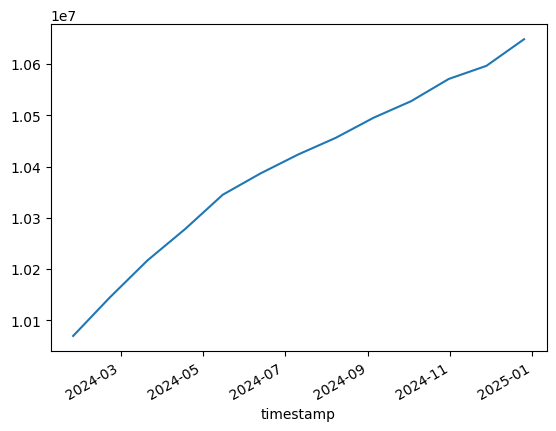

In [11]:
plot_df.dropna().total_capital.plot()

In [12]:
manager_ids = [m.manager_id for m in managers]
manager_ids

['CM_1', 'CM_2', 'CM_3', 'CM_Risk', 'CM_Conservative']

<Axes: xlabel='timestamp'>

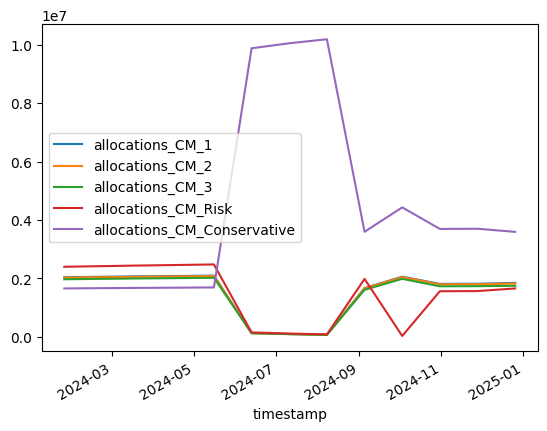

In [13]:
columns = [f'allocations_{m}' for m in manager_ids]
plot_df[columns].plot()

<Axes: xlabel='timestamp'>

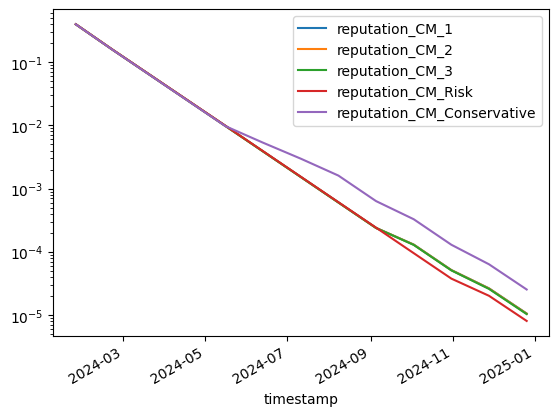

In [14]:
columns = [f'reputation_{m}' for m in manager_ids]
plot_df[columns].plot(logy=True)

<Axes: xlabel='timestamp'>

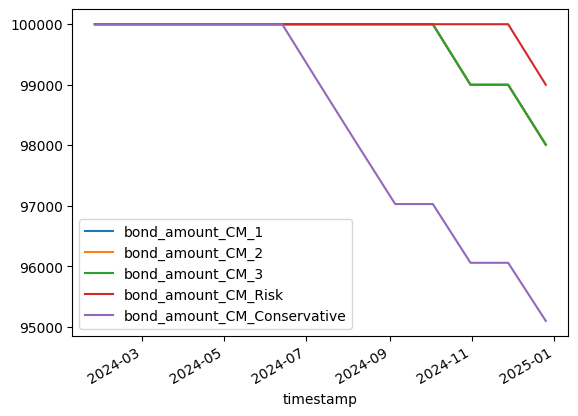

In [15]:
columns = [f'bond_amount_{m}' for m in manager_ids]
plot_df[columns].plot()